In [125]:
import os
import io
import sys
import gzip
import glob
import scipy
import sklearn
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from collections import defaultdict

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sns.set_palette("Set2")

import inStrain
import inStrain.SNVprofile


## Read in information

In [2]:
DATE = '02_04_2020'

PLdb = pd.read_csv('/home/mattolm/user_data/Covid_19/Pipeline/Jupyter/{0}_SRA_full_info.csv'.format(DATE))
PLdb = PLdb[PLdb['aligned_reads'] > 0]
PLdb['inStrain_succeeded'].value_counts()

True    95
Name: inStrain_succeeded, dtype: int64

In [156]:
saveloc = '/home/mattolm/user_data/Covid_19/Pipeline/Jupyter/{0}_tables/'.format(DATE)
figloc = '/home/mattolm/user_data/Covid_19/Pipeline/Jupyter/{0}_figures/'.format(DATE)

COdb = pd.read_csv(saveloc + 'COVID_genome_coverage.csv')
Odb = pd.read_csv(saveloc + 'COVID_positional_coverage_v2.csv')
MGdb = pd.read_csv(saveloc + 'COVID_gene_coverage_v2.csv')
POdb = pd.read_csv('/home/mattolm/user_data/Covid_19/datatables/COVID_genes_positional_v2.2.csv')


In [4]:
save_loc = '/home/mattolm/user_data/Covid_19/Pipeline/Jupyter/{0}_figures/'.format(DATE)
if not os.path.isdir(save_loc):
    os.mkdir(save_loc)

# Define SNP caling methods

In [65]:
def gen_SNP_command(row, method, out_folder, **kwargs):
    '''
    Generate the command for calling a SNP
    
    row = pandas row
    method = string of method
    out_folder = output base folder
    '''
    out = gen_out_location(row, method, out_folder)
    
    if method == 'lofreq':
        cmd = gen_lofreq_cmd(row['bam_file'], kwargs.get('fasta'), out, **kwargs)
    elif method == 'bbtools':
        cmd = gen_bbtools_cmd(row['bam_file'], kwargs.get('fasta'), out, **kwargs)
    elif method == 'freebayes':
        cmd = gen_freebayes_cmd(row['bam_file'], kwargs.get('fasta'), out, **kwargs)
    elif method == 'bcftools':
        cmd = gen_bcftools_cmd(row['bam_file'], kwargs.get('fasta'), out, **kwargs)
    elif method == 'varscan':
        cmd = gen_varscan_cmd(row['bam_file'], kwargs.get('fasta'), out, **kwargs)
    elif method == 'iVar':
        cmd = gen_iVar_cmd(row['bam_file'], kwargs.get('fasta'), out, **kwargs)
    else:
        print("I dont know {0} cmd".format(method))
        cmd = None
        out = None
    return cmd, out

def gen_out_location(row, method, out_folder):
    '''
    Get the output location for a particular SNP method
    '''
    if method in ['lofreq', 'bbtools', 'freebayes', 'bcftools']:
        return os.path.join(out_folder, row['Run'] + '.vcf')
    elif method in ['varscan']:
        return os.path.join(out_folder, row['Run'] + '.txt')
    elif method in ['iVar']:
        return os.path.join(out_folder, row['Run'] + '/' + row['Run'] + '.variants.tsv')
    else:
        print("I dont know {0} out".format(method))

def gen_lofreq_cmd(bam, fasta_loc, output, **kwargs):
    threads = kwargs.get('threads', 1)
    
    cmd = "lofreq call-parallel --pp-threads {3} -f {0} -o {1} {2}".format(fasta_loc, bam, output, threads)
    return cmd

def gen_bbtools_cmd(bam, fasta_loc, output, **kwargs):
    threads = kwargs.get('threads', 1)
    
    cmd = "callvariants.sh in={0} ref={1} out={2} ss={3}".format(bam, fasta_loc, output, threads)
    return cmd

def gen_freebayes_cmd(bam, fasta_loc, output, **kwargs):
    threads = kwargs.get('threads', 1)
    
    cmd = "freebayes -f {0} --pooled-continuous {1} > {2}".format(fasta_loc, bam, output)
    return cmd

def gen_bcftools_cmd(bam, fasta_loc, output, **kwargs):
    threads = kwargs.get('threads', 1)
    
    cmd = "bcftools mpileup -f {0} {1} | bcftools call -mv -Ob --ploidy 1 | bcftools view -i '%QUAL>=20' > {2}".format(fasta_loc, bam, output)
    return cmd

def gen_varscan_cmd(bam, fasta_loc, output, **kwargs):
    threads = kwargs.get('threads', 1)
    
    cmd = "samtools mpileup -f {0} {1} | varscan pileup2snp > {2}".format(fasta_loc, bam, output)
    return cmd

def gen_iVar_cmd(bam, fasta_loc, output, **kwargs):
    threads = kwargs.get('threads', 1)
    Run = kwargs.get('Run', None)
    assert Run != None
    
    PRIMER_BED = kwargs.get('PRIMER_BED', '/home/mattolm/user_data/Covid_19/SNPs/iVar/primers/Primers_v1_3.bed')
    PRIMER_FASTA = kwargs.get('PRIMER_FASTA', '/home/mattolm/user_data/Covid_19/SNPs/iVar/primers/Primers_v1_3.fasta')
    PRIMER_PAIRS = kwargs.get('PRIMER_PAIRS', '/home/mattolm/user_data/Covid_19/SNPs/iVar/primers/Primers_v1_3.pair_information.tsv')
    
    iVar_dir = '/'.join(output.split('/')[:-1]) + '/'
    if not os.path.isdir(iVar_dir):
        os.mkdir(iVar_dir)
        
    full_cmd = ''
    
    # Remove unmapped reads
    unmapped_bam = os.path.join(iVar_dir, os.path.basename(bam)) + '.unmapped'
    cmd = "samtools view -F 4 -b -o {0} {1} && samtools index {0}".format(unmapped_bam, bam)
    full_cmd += cmd + ' && '
    
    # Trim primer sequences
    trimmed_bam_loc = os.path.join(iVar_dir, os.path.basename(bam)) + '.trimmed'
    final_trimmed_loc = trimmed_bam_loc + '.bam.sorted'
    cmd = "ivar trim -b {0} -p {1} -i {2} && samtools sort {1}.bam -o {1}.bam.sorted && samtools index {1}.bam.sorted".format(PRIMER_BED, trimmed_bam_loc, unmapped_bam)
    full_cmd += cmd + ' && '
    
    # Create and index consensus sequence
    consensus = os.path.join(iVar_dir, Run) + '.consensus'
    cmd = "samtools mpileup -A -d 0 -Q 0 {0} | ivar consensus -p {1} && bwa index {1}.fa".format(final_trimmed_loc, consensus)
    full_cmd += cmd + ' && '
    #print(cmd)
    
    # Map primers back to consensus
    primer_bam = os.path.join(iVar_dir, Run) + '.primers.consensus.bam'
    cmd = "bwa mem -k 5 -T 6 {0}.fa {1} | samtools view -bS -F 4 | samtools sort -o {2}".format(consensus, PRIMER_FASTA, primer_bam)
    full_cmd += cmd + ' && '
    
    # Call iSNVs on this primer bam
    primer_variants = os.path.join(iVar_dir, Run) + '.primers'
    primer_variants_loc = primer_variants + '.tsv'
    cmd = "samtools mpileup -A -d 0 --reference {0}.fa -Q 0 {1} | ivar variants -p {2} -t 0.03".format(consensus, primer_bam, primer_variants)
    full_cmd += cmd + ' && '
    
    # Get indicies of primers with mismatches and their pairs
    primer_mm =  os.path.join(iVar_dir, Run) + '.primer_mismatch_indicies'
    con_bed = os.path.join(iVar_dir, Run) + '.primers.consensus.bed'
    cmd = "bedtools bamtobed -i {0} > {1} && ivar getmasked -i {2} -b {1} -f {3} -p {4}".format(primer_bam, con_bed, primer_variants_loc, PRIMER_PAIRS, primer_mm)
    full_cmd += cmd + ' && '
    
    # Remove these amplicons I guess
    masked_bam = os.path.join(iVar_dir, os.path.basename(bam)) + '.masked.bam'
    cmd = "ivar removereads -i {0} -p {1} -t {2}.txt -b {3} && samtools sort -o {1}.sorted {1}".format(final_trimmed_loc, masked_bam, primer_mm, PRIMER_BED)
    full_cmd += cmd + ' && '
    
    # Call SNPs on this masked bam
    variant_loc =  os.path.join(iVar_dir, Run) + '.variants'
    cmd = "samtools mpileup -A -d 0 --reference {0} -Q 0 {1}.sorted | ivar variants -p {2} -t 0.03".format(fasta, masked_bam, variant_loc)
    full_cmd += cmd 
    
    # Add some logging
    log_loc = os.path.join(iVar_dir, Run + '.ivar.log')
    full_cmd += " 2> {0}".format(log_loc)
    
    # Done
    return full_cmd

# Run SNPs that need to be

In [86]:
out_base = '/home/mattolm/user_data/Covid_19/SNPs/'
cmd_loc = '/home/mattolm/user_data/Covid_19/Pipeline/Jupyter/cmds/{0}_SNP_cmds.txt'.format(DATE)
o = open(cmd_loc, 'w')
for i, row in PLdb.iterrows():
    for method in ['lofreq', 'bbtools', 'freebayes', 'bcftools', 'varscan', 'iVar']:
        
        # Make the output folder
        out_folder = os.path.join(out_base, method) + '/'
        
        # Make the command
        cmd, outfile = gen_SNP_command(row, method, out_folder, fasta='/home/mattolm/user_data/Covid_19/genomes/NC_045512.2.fasta', Run=row['Run'])
        
#         if method == 'bcftools':
#             print(outfile)
#             break
        
        # See if the output file already exists
        if os.path.exists(outfile):
            #print(method)
            pass
        else:
            o.write(cmd + '\n')
            
o.close()

In [87]:
print("cat {0} | parallel -j 10".format(cmd_loc))

cat /home/mattolm/user_data/Covid_19/Pipeline/Jupyter/cmds/02_04_2020_SNP_cmds.txt | parallel -j 10


# Load SNPs

In [134]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    db = pd.read_csv(io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t').rename(columns={'#CHROM': 'CHROM'}).reset_index()
    
    dbs2 = []
    for i, row in db.iterrows():
        db2 = make_db2(row['INFO'])
        db2['index'] = row['index']
        dbs2.append(db2)
    if len(dbs2) > 0:
        db2 = pd.concat(dbs2)
        db = pd.merge(db, db2, on='index')
    del db['index']
    
    return db

def read_vcf_gz(path):
    with gzip.open(path, 'rb') as f:
        lines = [l.decode('ascii') for l in f if not l.decode('ascii').startswith('##')]
    db =  pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'}).reset_index()
    
    dbs2 = []
    for i, row in db.iterrows():
        db2 = make_db2(row['INFO'])
        db2['index'] = row['index']
        dbs2.append(db2)
    if len(dbs2) > 0:
        db2 = pd.concat(dbs2)
        db = pd.merge(db, db2, on='index')
    del db['index']
    
    return db

def make_db2(INFO):
    table = defaultdict(list)
    for thing in INFO.split(';'):
        if '=' not in thing:
            table[thing] = True
        else:
            table[thing.split('=')[0]].append(thing.split('=')[1])
    return pd.DataFrame(table)


def load_snps(outfile, method):
    if method in ['lofreq', 'bbtools', 'freebayes', 'bcftools']:
        return read_vcf(outfile)
    if method in ['varscan', 'iVar']:
        return pd.read_csv(outfile, sep='\t')
    else:
        print("I dont know method {0}".format(method))
        asdf
    
    return pd.DataFrame()

# Load on the run-level
method2tables = defaultdict(list)
for i, row in PLdb.iterrows():
    for method in ['lofreq', 'bbtools', 'freebayes', 'bcftools', 'varscan', 'iVar']:
        # Make the output folder
        out_folder = os.path.join(out_base, method) + '/'
        
        # Find the outfile
        outfile = gen_out_location(row, method, out_folder)
        
        if not os.path.exists(outfile):
            print("{0} doesnt exist".format(outfile))
            continue
        
        # Load the database
        db = load_snps(outfile, method)
        db['Run'] = row['Run']
        method2tables[method].append(db)
        
# Load special ones
for i, row in PLdb.iterrows():
    loc = row['inStrain_coverage'].replace('_scaffold_info.tsv', '_SNVs.tsv')
    try:
        db = pd.read_csv(loc, sep='\t')
        # Make it 1-based
        db['position'] = db['position'] + 1
    except:
        db = pd.DataFrame()
        
    db['Run'] = row['Run']
    method2tables['inStrain'].append(db)

for f in glob.glob('/home/dahan/user_data/Projects/COVID19/ONE_CODEX/vcf_out/*.vcf.gz') + glob.glob('/home/dahan/user_data/Projects/COVID19/3_28_2020_ONE_CODEX/*.vcf.gz'):
    db = read_vcf_gz(f)
    db['Run'] = os.path.basename(f).split('_')[1]
    method2tables['onecodex'].append(db)

/home/mattolm/user_data/Covid_19/SNPs/iVar/SRR11454612/SRR11454612.variants.tsv doesnt exist
/home/mattolm/user_data/Covid_19/SNPs/iVar/SRR11412227/SRR11412227.variants.tsv doesnt exist


In [141]:
# Make into dataframes
method2frame = {}
for method, tables in method2tables.items():
    db = pd.concat(tables)
    db['method'] = method
    db[method] = True
    
    if method in ['lofreq', 'bbtools', 'freebayes', 'bcftools', 'varscan', 'iVar', 'onecodex']:
        db = db.rename(columns={'CHROM':'scaffold', 'POS':'position', 'Chrom':'scaffold', 'Position':'position', 'REGION':'scaffold'})
        
    if method in ['bbtools', 'bcftools']:
        db = db[[c for c in list(db.columns) if 'bt2-vs-' not in c]]
    
    method2frame[method] = db

# Compare SNP callers

In [142]:
for caller, db in method2frame.items():
    assert 'position' in list(db.columns), caller
    assert 'scaffold' in list(db.columns), caller
    print("{0:10} has {1} samples".format(caller, len(db['Run'].unique())))

lofreq     has 92 samples
bbtools    has 62 samples
freebayes  has 95 samples
bcftools   has 84 samples
varscan    has 94 samples
iVar       has 80 samples
inStrain   has 94 samples
onecodex   has 21 samples


## Save

In [159]:
snp_loc = saveloc + 'SNPs/'
print(snp_loc)

for caller, db in method2frame.items():
    db.to_csv("{0}{1}_snps.csv.gz".format(snp_loc, caller), index=False)

/home/mattolm/user_data/Covid_19/Pipeline/Jupyter/02_04_2020_tables/SNPs/


## Make a combined DataFrame

In [146]:
def merge_SNPS(CALLER2DB):
    Mdb = None
    callers = []
    dbs = []
    for c, d in CALLER2DB.items():
        callers.append(c)
        dbs.append(d)
    for i, db in enumerate(dbs):
        if i == 0:
            continue
        elif i == 1:
            Mdb = pd.merge(dbs[0], dbs[1], on=['scaffold', 'position', 'Run'], how='outer')
        else:
            Mdb = pd.merge(Mdb, dbs[i], on=['scaffold', 'position', 'Run'], how='outer')
            
    Mdb = Mdb[['scaffold', 'position', 'Run'] + callers]
    Mdb['position'] = Mdb['position'].astype(int)
    Mdb = Mdb.fillna(False)
    return Mdb

MSdb = merge_SNPS(method2frame)
MSdb.head()

,scaffold,position,Run,lofreq,bbtools,freebayes,bcftools,varscan,iVar,inStrain,onecodex
0,NC_045512.2,28144,SRR11454606,True,True,True,True,True,False,True,False
1,NC_045512.2,5657,SRR11454607,True,True,True,True,True,True,True,False
2,NC_045512.2,6604,SRR11454607,True,False,False,False,True,False,True,False
3,NC_045512.2,8782,SRR11454607,True,True,True,True,True,True,True,False
4,NC_045512.2,12413,SRR11454607,True,False,False,False,True,True,True,False


## Quantify number of SNPs called by every method

In [147]:
import random
callers = [c for c, d in method2frame.items()]
random.shuffle(callers)

table = defaultdict(list)
for run, db in MSdb.groupby('Run'):
    table['Run'].append(run)
    for c in callers:
        if len(db[~db[c].isna()]) > 0:  
            table[c].append(len(db[db[c] == True]))
        else:
            table[c].append(np.nan)
Rdb = pd.DataFrame(table)
Rdb.head()

,Run,onecodex,bbtools,lofreq,varscan,iVar,inStrain,freebayes,bcftools
0,SRR11059940,3,6,7,46,229,104,35,3
1,SRR11059941,0,12,0,0,1,0,31,0
2,SRR11059942,10,1,238,1284,1182,1410,309,40
3,SRR11059943,45,7,138,300,11,443,246,69
4,SRR11059944,0,2,86,429,138,118,10,0


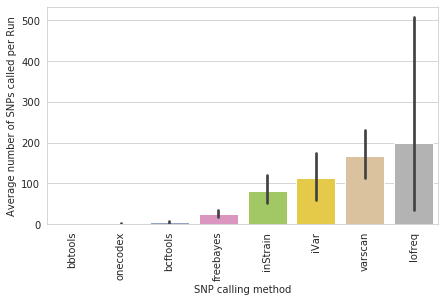

In [160]:
fdb = Rdb.melt(id_vars='Run')

# Sort
order = fdb.groupby('variable')['value'].mean().to_frame().sort_values('value').reset_index()['variable'].tolist()
fdb['variable'] = fdb['variable'].astype('category')
fdb['variable'].cat.reorder_categories(order, inplace=True)
fdb = fdb.sort_values('variable')

sns.barplot(data=fdb, x='variable', y='value')
plt.xticks(rotation=90)
plt.xlabel('SNP calling method')
plt.ylabel("Average number of SNPs called per Run")

plt.gcf().set_size_inches(7, 4)
plt.gcf().savefig(figloc + 'SNV_totals_{0}.png'.format(DATE), bbox_inches='tight', dpi=200)
plt.show()